**Install requirements**

In [3]:
pip install pyramid-arima

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
#!pip uninstall scikit-learn
!pip install scikit-learn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -m pip install --upgrade pip' command.


In [10]:
!pip install chart_studio

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3 -m pip install --upgrade pip' command.


***Import Libraries***

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go
import xgboost as xgb
import keras.backend as K
import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pyramid.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, TimeDistributed, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [12]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [13]:
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#Upload train data set file from local to colabs area
uploaded = files.upload()

In [18]:
# Load Train dataset
train = pd.read_csv("data/Litecoin_Historica_Data.csv")
train.head(5).append(train.tail(5))

,Date,Price,Open,High,Low,Vol.,Change %
0,"Sep 03, 2020",56.752,58.060,58.600,56.292,14.60M,-2.30%
1,"Sep 02, 2020",58.087,62.697,63.168,56.658,14.91M,-7.40%
2,"Sep 01, 2020",62.730,60.957,64.273,59.857,13.69M,2.91%
3,"Aug 31, 2020",60.957,62.870,63.677,60.588,14.61M,-3.04%
4,"Aug 30, 2020",62.870,56.952,62.883,56.931,14.95M,10.39%
393,"Aug 07, 2019",90.546,93.042,94.286,87.764,10.54M,-2.69%
394,"Aug 06, 2019",93.049,96.508,99.246,91.217,11.28M,-3.58%
395,"Aug 05, 2019",96.504,92.700,106.384,92.700,15.38M,4.10%
396,"Aug 04, 2019",92.701,94.190,94.740,90.548,8.48M,-1.58%
397,"Aug 03, 2019",94.192,94.780,96.552,93.652,8.28M,-0.61%


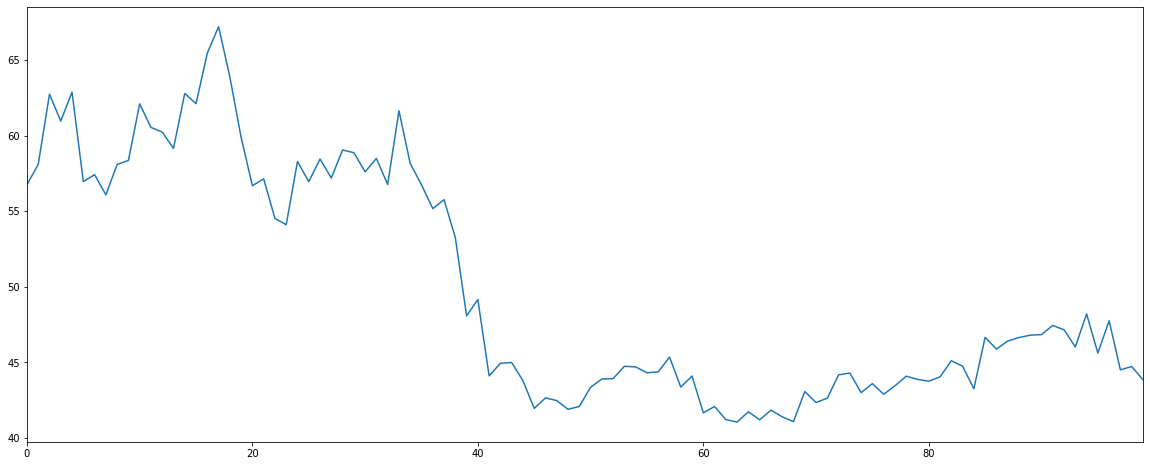

In [19]:
#Plot data
train[:100].Price.plot(figsize=(20,8))

In [20]:
train.shape

(398, 7)

In [21]:
train.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

# **Preprocess**

In [22]:
train = train.set_index(['Date'])

In [23]:
train.index = pd.to_datetime(train.index)

In [24]:
train.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [25]:
#Stationary Control
#if P-Value is smaller than 0.005, we can say that there is stationary, else there is no stationary
#if our data has no stationary, I will plan to use differences

class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Dickey-Fuller test:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Add Critical Values
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [26]:
sTest = Stationary()

In [27]:
sTest.ADF_Stationarity_Test(train['Price'])
print(sTest.isStationary)

Date
2020-09-03    56.752
2020-09-02    58.087
2020-09-01    62.730
2020-08-31    60.957
2020-08-30    62.870
               ...  
2019-08-07    90.546
2019-08-06    93.049
2019-08-05    96.504
2019-08-04    92.701
2019-08-03    94.192
Name: Price, Length: 398, dtype: float64
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.932764
P-Value                   0.776991
# Lags Used               4.000000
# Observations Used     393.000000
Critical Value (1%)      -3.447099
Critical Value (5%)      -2.868923
Critical Value (10%)     -2.570703
dtype: float64
False


## **P-Values is higher than 0.005, so there no stationary.**

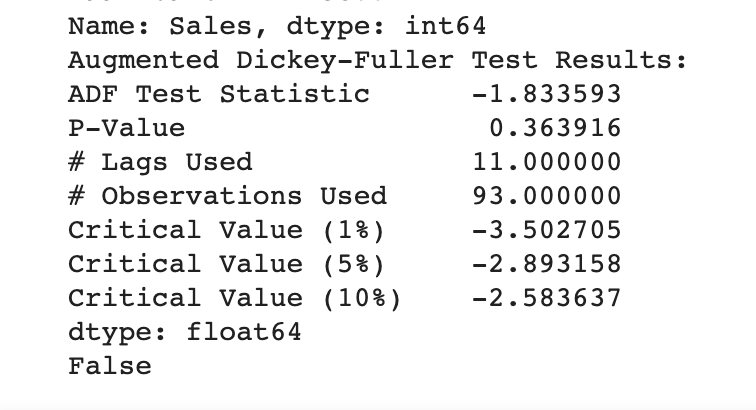

In [28]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [29]:
diff_values = difference(train['Price'], 1)

In [30]:
 # split train test datasets
 xtrain, xtest = diff_values[0:-7], diff_values[-7:]

In [31]:
xtest

390   -1.181
391    5.878
392    0.337
393    2.503
394    3.455
395   -3.803
396    1.491
dtype: float64

In [32]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [33]:
# scale train and test data to [-1, 1] with MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  
    
    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    
    return scaler, tr_scaled, ts_scaled

In [34]:
# reorganize dataset acording to window size
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [35]:
supervised_raw

,0 (t-12),0 (t-11),0 (t-10),0 (t-9),0 (t-8),0 (t-7),0 (t-6),0 (t-5),0 (t-4),0 (t-3),0 (t-2),0 (t-1),0 (t-0)
12,1.335,4.643,-1.773,1.913,-5.918,0.460,-1.336,2.011,0.262,3.743,-1.555,-0.309,-1.076
13,4.643,-1.773,1.913,-5.918,0.460,-1.336,2.011,0.262,3.743,-1.555,-0.309,-1.076,3.631
14,-1.773,1.913,-5.918,0.460,-1.336,2.011,0.262,3.743,-1.555,-0.309,-1.076,3.631,-0.678
15,1.913,-5.918,0.460,-1.336,2.011,0.262,3.743,-1.555,-0.309,-1.076,3.631,-0.678,3.345
16,-5.918,0.460,-1.336,2.011,0.262,3.743,-1.555,-0.309,-1.076,3.631,-0.678,3.345,1.748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2.014,-0.807,-3.610,1.972,1.641,-0.316,8.903,0.895,4.326,-4.595,-1.181,5.878,0.337
393,-0.807,-3.610,1.972,1.641,-0.316,8.903,0.895,4.326,-4.595,-1.181,5.878,0.337,2.503
394,-3.610,1.972,1.641,-0.316,8.903,0.895,4.326,-4.595,-1.181,5.878,0.337,2.503,3.455
395,1.972,1.641,-0.316,8.903,0.895,4.326,-4.595,-1.181,5.878,0.337,2.503,3.455,-3.803


In [36]:
supervised_raw = supervised_raw.values.astype("float32")

In [37]:
supervised_raw

array([[ 1.335,  4.643, -1.773, ..., -1.555, -0.309, -1.076],
       [ 4.643, -1.773,  1.913, ..., -0.309, -1.076,  3.631],
       [-1.773,  1.913, -5.918, ..., -1.076,  3.631, -0.678],
       ...,
       [-3.61 ,  1.972,  1.641, ...,  0.337,  2.503,  3.455],
       [ 1.972,  1.641, -0.316, ...,  2.503,  3.455, -3.803],
       [ 1.641, -0.316,  8.903, ...,  3.455, -3.803,  1.491]],
      dtype=float32)

In [38]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))

In [39]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [40]:
supervised = timeseries_to_supervised(values_scaled, 12)

supervised_values = supervised.values.astype('float32')

##split supervised data into train and test-sets
supervised_train, supervised_test = supervised_raw[0:-9], supervised_raw[-9:]
train_scaled, test_scaled = supervised_values[0:-9], supervised_values[-9:]

In [41]:
train_scaled

array([[0.3717777 , 0.49137712, 0.25940922, ..., 0.26729095, 0.31233957,
        0.284609  ],
       [0.49137712, 0.25940922, 0.39267507, ..., 0.31233957, 0.284609  ,
        0.45478868],
       [0.25940922, 0.39267507, 0.10954843, ..., 0.284609  , 0.45478868,
        0.2989985 ],
       ...,
       [0.347988  , 0.27040023, 0.36592066, ..., 0.3948082 , 0.38284102,
        0.3120865 ],
       [0.27040023, 0.36592066, 0.40001446, ..., 0.38284102, 0.3120865 ,
        0.6453957 ],
       [0.36592066, 0.40001446, 0.25351605, ..., 0.3120865 , 0.6453957 ,
        0.3558697 ]], dtype=float32)

In [42]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [43]:
train_y.reshape(train_y.shape[0], 1)

array([[0.284609  ],
       [0.45478868],
       [0.2989985 ],
       [0.44444847],
       [0.38670957],
       [0.20355038],
       [0.1784591 ],
       [0.20821433],
       [0.33992553],
       [0.22889476],
       [0.30854332],
       [0.4746014 ],
       [0.2753534 ],
       [0.37763476],
       [0.27795655],
       [0.39068657],
       [0.31700352],
       [0.27784806],
       [0.355472  ],
       [0.26114467],
       [0.4998373 ],
       [0.19765718],
       [0.27220798],
       [0.26671246],
       [0.34484255],
       [0.23319715],
       [0.13604975],
       [0.3625583 ],
       [0.14082216],
       [0.35384503],
       [0.32510215],
       [0.28019813],
       [0.25731227],
       [0.34856647],
       [0.31703967],
       [0.30268627],
       [0.33034456],
       [0.36939153],
       [0.34325173],
       [0.32445136],
       [0.35297734],
       [0.32206514],
       [0.30941105],
       [0.32571676],
       [0.35894284],
       [0.2517806 ],
       [0.34986803],
       [0.235

In [44]:
# prepare train dataset for lstm
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [45]:
# prepare test dataset for lstm
train_Y_lstm = train_y.reshape((train_y.shape[0], 1, 1))
test_Y_lstm = test_y.reshape((test_y.shape[0], 1, 1))

In [46]:
test_scaled[:, -1]

array([0.47991613, 0.15738097, 0.28081277, 0.536028  , 0.33569545,
       0.4140063 , 0.44842547, 0.1860154 , 0.37741783], dtype=float32)

In [47]:
train_y

array([0.284609  , 0.45478868, 0.2989985 , 0.44444847, 0.38670957,
       0.20355038, 0.1784591 , 0.20821433, 0.33992553, 0.22889476,
       0.30854332, 0.4746014 , 0.2753534 , 0.37763476, 0.27795655,
       0.39068657, 0.31700352, 0.27784806, 0.355472  , 0.26114467,
       0.4998373 , 0.19765718, 0.27220798, 0.26671246, 0.34484255,
       0.23319715, 0.13604975, 0.3625583 , 0.14082216, 0.35384503,
       0.32510215, 0.28019813, 0.25731227, 0.34856647, 0.31703967,
       0.30268627, 0.33034456, 0.36939153, 0.34325173, 0.32445136,
       0.35297734, 0.32206514, 0.30941105, 0.32571676, 0.35894284,
       0.2517806 , 0.34986803, 0.23543873, 0.33869627, 0.2922376 ,
       0.31765428, 0.34802416, 0.3042771 , 0.34668642, 0.30756715,
       0.31201416, 0.3955313 , 0.29715464, 0.33377925, 0.37940633,
       0.32788604, 0.276655  , 0.34498715, 0.29809466, 0.34364945,
       0.34661412, 0.31591886, 0.31913662, 0.3338877 , 0.362016  ,
       0.31042337, 0.26964098, 0.44647312, 0.29531074, 0.34270

In [48]:
train_y.shape

(376,)

# **XGBRegressor**

In [49]:
# XGBRegressor Training
now = datetime.now()
print("Process started at : ",now)

parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
              'max_depth' : [2, 4, 6, 7, 12], 
              'n_estimators' : [10, 45, 90, 100, 150, 250],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

end = datetime.now()
print("Process finished at : ", end)
print("Process took : ", end-now)

Process started at :  2020-09-03 14:03:30.107980
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   13.7s


[0]	validation_0-rmse:0.18140
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.16826
[2]	validation_0-rmse:0.15679
[3]	validation_0-rmse:0.14681
[4]	validation_0-rmse:0.13817
[5]	validation_0-rmse:0.13073
[6]	validation_0-rmse:0.12436
[7]	validation_0-rmse:0.11892
[8]	validation_0-rmse:0.11431
[9]	validation_0-rmse:0.11042
[10]	validation_0-rmse:0.10714
[11]	validation_0-rmse:0.10440
[12]	validation_0-rmse:0.10211
[13]	validation_0-rmse:0.10020
[14]	validation_0-rmse:0.09862
[15]	validation_0-rmse:0.09731
[16]	validation_0-rmse:0.09622
[17]	validation_0-rmse:0.09533
[18]	validation_0-rmse:0.09459
[19]	validation_0-rmse:0.09398
[20]	validation_0-rmse:0.09348
[21]	validation_0-rmse:0.09306
[22]	validation_0-rmse:0.09272
[23]	validation_0-rmse:0.09243
[24]	validation_0-rmse:0.09220
[25]	validation_0-rmse:0.09201
[26]	validation_0-rmse:0.09185
[27]	validation_0-rmse:0.09171
[28]	validation_0-rmse:0.09160
[29]	validation_0-rmse:0.09151
[30]	validation

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   17.3s finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [50]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=10, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, seed=10, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    inverted = scaler.inverse_transform(array)
    ##print("converting %s to %s" % (value,inverted[0, -1]))
    return inverted[0, -1]

In [52]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [54]:
#Invert scale predictions to time series
predictions = list()
start = 9 # test period
l = len(test_scaled) - start

rmse = []
mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    # prediction 
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)
        
    l=l+1

    yhat = inverse_difference(train['Price'], yhat, len(test_scaled) + 1 - i) # if not stationary 

    predictions.append(yhat)

    rmse.append(sqrt(mean_squared_error([train['Price'][-9:][i]], [yhat])))
    mape.append(mean_absolute_percentage_error([train['Price'][-9:][i]], [yhat]))

In [55]:
print("Test RMSE:", np.mean(rmse))
print("Test MAPE:", np.mean(mape))

Test RMSE: 3.0157624802125804
Test MAPE: 3.331412908002431


In [56]:
predictions

[85.92337922602893,
 90.24937922602894,
 85.65437922602892,
 84.47337922602892,
 90.35137922602893,
 90.68837922602893,
 93.19137922602891,
 96.64637922602891,
 92.84337922602893]

In [57]:
result_df = pd.read_csv("data/Litecoin_Historica_Data.csv")

In [58]:
result_df = result_df[-9:]

In [59]:
result_df.head(9)

,Date,Price,Open,High,Low,Vol.,Change %
389,"Aug 11, 2019",90.107,85.497,91.499,85.422,9.97M,5.37%
390,"Aug 10, 2019",85.512,84.321,87.436,82.623,11.08M,1.40%
391,"Aug 09, 2019",84.331,90.206,90.418,82.753,11.34M,-6.52%
392,"Aug 08, 2019",90.209,90.568,92.130,88.112,10.68M,-0.37%
393,"Aug 07, 2019",90.546,93.042,94.286,87.764,10.54M,-2.69%
394,"Aug 06, 2019",93.049,96.508,99.246,91.217,11.28M,-3.58%
395,"Aug 05, 2019",96.504,92.700,106.384,92.700,15.38M,4.10%
396,"Aug 04, 2019",92.701,94.190,94.740,90.548,8.48M,-1.58%
397,"Aug 03, 2019",94.192,94.780,96.552,93.652,8.28M,-0.61%


In [60]:
result_df['XGB_Predictions'] = predictions
result_df.head(9)

,Date,Price,Open,High,Low,Vol.,Change %,XGB_Predictions
389,"Aug 11, 2019",90.107,85.497,91.499,85.422,9.97M,5.37%,85.923379
390,"Aug 10, 2019",85.512,84.321,87.436,82.623,11.08M,1.40%,90.249379
391,"Aug 09, 2019",84.331,90.206,90.418,82.753,11.34M,-6.52%,85.654379
392,"Aug 08, 2019",90.209,90.568,92.130,88.112,10.68M,-0.37%,84.473379
393,"Aug 07, 2019",90.546,93.042,94.286,87.764,10.54M,-2.69%,90.351379
394,"Aug 06, 2019",93.049,96.508,99.246,91.217,11.28M,-3.58%,90.688379
395,"Aug 05, 2019",96.504,92.700,106.384,92.700,15.38M,4.10%,93.191379
396,"Aug 04, 2019",92.701,94.190,94.740,90.548,8.48M,-1.58%,96.646379
397,"Aug 03, 2019",94.192,94.780,96.552,93.652,8.28M,-0.61%,92.843379


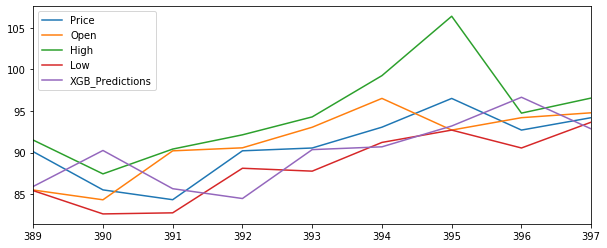

In [61]:
result_df[:9].plot(figsize=(10,4))

In [62]:
train.head(5).append(train.tail(5))

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-09-03,56.752,58.060,58.600,56.292,14.60M,-2.30%
2020-09-02,58.087,62.697,63.168,56.658,14.91M,-7.40%
2020-09-01,62.730,60.957,64.273,59.857,13.69M,2.91%
2020-08-31,60.957,62.870,63.677,60.588,14.61M,-3.04%
2020-08-30,62.870,56.952,62.883,56.931,14.95M,10.39%
2019-08-07,90.546,93.042,94.286,87.764,10.54M,-2.69%
2019-08-06,93.049,96.508,99.246,91.217,11.28M,-3.58%
2019-08-05,96.504,92.700,106.384,92.700,15.38M,4.10%
2019-08-04,92.701,94.190,94.740,90.548,8.48M,-1.58%


# **AutoArima**

In [63]:
train[:-9].head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-09-03,56.752,58.060,58.600,56.292,14.60M,-2.30%
2020-09-02,58.087,62.697,63.168,56.658,14.91M,-7.40%
2020-09-01,62.730,60.957,64.273,59.857,13.69M,2.91%
2020-08-31,60.957,62.870,63.677,60.588,14.61M,-3.04%
2020-08-30,62.870,56.952,62.883,56.931,14.95M,10.39%
2020-08-29,56.952,57.410,58.188,56.952,11.65M,-0.80%
2020-08-28,57.412,56.083,58.184,55.334,13.96M,2.38%
2020-08-27,56.076,58.087,59.232,54.046,12.69M,-3.46%
2020-08-26,58.087,58.347,59.062,57.028,11.47M,-0.45%


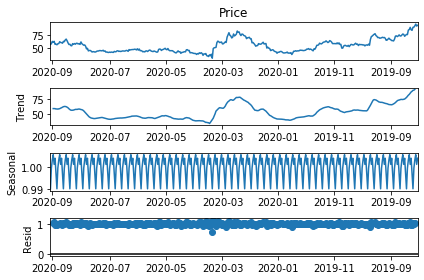

In [64]:
result = seasonal_decompose(train.Price, model='multiplicative')
fig = result.plot()

In [65]:
arima_train = train[:-9].Price
arima_test = train[-9:].Price

(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [66]:
# Arima Training
now = datetime.now()
print("Arima process started at : ",now)

arima_stepwise_model = auto_arima(arima_train, start_p=0, start_q=0,
                           max_p=13, max_q=13, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           n_jobs=10)#n_jobs for parallel process
end = datetime.now()
print("Arima process finished at : ", end)
print("Process took : ", end-now)

print(arima_stepwise_model)

Arima process started at :  2020-09-03 14:04:41.626021


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1809.345, BIC=1821.133, Fit time=0.684 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2022.575, BIC=2030.434, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1919.766, BIC=1935.484, Fit time=0.320 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1808.306, BIC=1824.024, Fit time=1.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1810.303, BIC=1829.951, Fit time=1.713 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2020.401, BIC=2032.190, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1810.303, BIC=1829.951, Fit time=3.564 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1811.929, BIC=1835.506, Fit time=5.639 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1804.089, BIC=1823.737, Fit time=1.764 seconds
Fit ARIMA: order=(1, 1, 0) s

In [67]:
# Fit arima model
arima_predicts = arima_stepwise_model.fit(arima_train)

In [68]:
# Predict results with auto-arima
future_forecast = arima_predicts.predict(n_periods=9)

In [69]:
future_forecast

array([86.29182941, 85.97485477, 85.92159404, 86.26212298, 86.94813048,
       87.89882636, 88.45073568, 89.43574538, 90.13904813])

In [70]:
arima_rmse = sqrt(mean_squared_error(train['Price'][-9:], future_forecast))

In [71]:
arima_mape = mean_absolute_percentage_error(train['Price'][-9:], future_forecast)

In [72]:
print("Test RMSE:", np.mean(arima_rmse))
print("Test MAPE:", np.mean(arima_mape))

Test RMSE: 4.272520922109963
Test MAPE: 4.079484487138648


In [73]:
result_df['Arima_Predictions'] = future_forecast
result_df.head(9)

,Date,Price,Open,High,Low,Vol.,Change %,XGB_Predictions,Arima_Predictions
389,"Aug 11, 2019",90.107,85.497,91.499,85.422,9.97M,5.37%,85.923379,86.291829
390,"Aug 10, 2019",85.512,84.321,87.436,82.623,11.08M,1.40%,90.249379,85.974855
391,"Aug 09, 2019",84.331,90.206,90.418,82.753,11.34M,-6.52%,85.654379,85.921594
392,"Aug 08, 2019",90.209,90.568,92.130,88.112,10.68M,-0.37%,84.473379,86.262123
393,"Aug 07, 2019",90.546,93.042,94.286,87.764,10.54M,-2.69%,90.351379,86.948130
394,"Aug 06, 2019",93.049,96.508,99.246,91.217,11.28M,-3.58%,90.688379,87.898826
395,"Aug 05, 2019",96.504,92.700,106.384,92.700,15.38M,4.10%,93.191379,88.450736
396,"Aug 04, 2019",92.701,94.190,94.740,90.548,8.48M,-1.58%,96.646379,89.435745
397,"Aug 03, 2019",94.192,94.780,96.552,93.652,8.28M,-0.61%,92.843379,90.139048


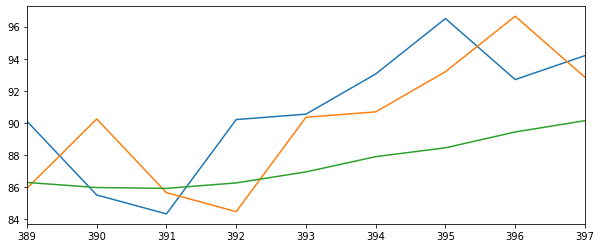

In [82]:
result_df[:9].Price.plot(figsize=(10,4))
result_df[:9].XGB_Predictions.plot(figsize=(10,4))
result_df[:9].Arima_Predictions.plot(figsize=(10,4))

# **Long Short - Term Memory (LSTM)**

In [75]:
# define parameters
verbose, epochs, batch_size = 1, 50, 10
n_timesteps, n_features, n_outputs = train_X_lstm.shape[1], train_X_lstm.shape[2], train_Y_lstm.shape[1]

In [76]:
n_timesteps, n_features, n_outputs

(1, 12, 1)

In [83]:
from tensorflow.keras.models import Sequential

In [88]:
!pip install --ignore-installed --upgrade "https://github.com/lakshayg/tensorflow-build"

     | 128 kB 554 kB/s
  ERROR: Cannot unpack file /private/var/folders/5l/_yv7wpm97ld4_76cqbsrmh64pdbvcz/T/pip-unpack-5qpszljm/tensorflow-build (downloaded from /private/var/folders/5l/_yv7wpm97ld4_76cqbsrmh64pdbvcz/T/pip-req-build-v_6j7drb, content-type: text/html; charset=utf-8); cannot detect archive format
ERROR: Cannot determine archive format of /private/var/folders/5l/_yv7wpm97ld4_76cqbsrmh64pdbvcz/T/pip-req-build-v_6j7drb


In [89]:
# define model
lstm_model = Sequential()
lstm_model.add(Conv1D(filters=32, kernel_size=5,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=(n_timesteps, n_features)))

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [ ]:
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
# lstm_model.add(RepeatVector(n_outputs))
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(1, activation='relu')))
#lstm_model.add(TimeDistributed(Dense(1)))
#lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001))
lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001),
              metrics=['acc'])

In [ ]:
train_X_lstm.shape, train_Y_lstm.shape

In [ ]:
now = datetime.now()

history = lstm_model.fit(train_X_lstm, train_Y_lstm, epochs=epochs, batch_size=batch_size, validation_data=(test_X_lstm, test_Y_lstm), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose, shuffle=False)

lstm_model.summary()

end = datetime.now()
print("LSTM process finished at : ", end)
print("LSTM process took : ", end-now)

In [ ]:
# Predict results with LSTM Model
lstm_predicts = lstm_model.predict(test_X_lstm, verbose=verbose)

In [ ]:
lstm_predicts

In [ ]:
test_scaled

In [ ]:
# Invert scaled predictons to time series
predictions = list()
start = 9 # test period
l = len(test_scaled) - start

lstm_rmse = []
lstm_mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    X1 = X1.reshape((1,-1))

    yhat = invert_scale(scaler, X1[0], lstm_predicts[i][0])
        
    l=l+1

    yhat = inverse_difference(train['Sales'], yhat, len(test_scaled) + 1 - i)

    predictions.append(yhat)

    lstm_rmse.append(sqrt(mean_squared_error([train['Sales'][-9:][i]], [yhat])))
    lstm_mape.append(mean_absolute_percentage_error([train['Sales'][-9:][i]], [yhat]))

In [ ]:
predictions

In [ ]:
print("LSTM RMSE:", np.mean(lstm_rmse))
print("LSTM MAPE:", np.mean(lstm_mape))

In [ ]:
result_df['LSTM_Predictions'] = predictions
result_df.head(9)

In [ ]:
result_df[:9].plot(figsize=(10,4))

In [ ]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)